<a href="https://colab.research.google.com/github/ManuelBagasina/DATCapstone/blob/main/TFT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Jupyter Setup

In [ ]:
!git clone -b main https://github.com/ManuelBagasina/DATCapstone.git
%cd DATCapstone/data

Cloning into 'DATCapstone'...
remote: Enumerating objects: 885, done.
remote: Counting objects: 100% (166/166), done.
remote: Compressing objects: 100% (65/65), done.
remote: Total 885 (delta 137), reused 101 (delta 101), pack-reused 719 (from 1)
Receiving objects: 100% (885/885), 99.14 MiB | 14.53 MiB/s, done.
Resolving deltas: 100% (477/477), done.
/content/DATCapstone/data


In [ ]:
# Installs
!pip install pytorch-lightning
!pip install pytorch-forecasting

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.0/823.0 kB 45.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 126.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 105.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 51.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 42.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 19.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 99.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 961.5/961.5 kB 43.2 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitli

In [ ]:
# Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import torch
import lightning.pytorch as pl
from pytorch_forecasting import TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import MAE, RMSE, SMAPE, QuantileLoss
import os
import warnings
warnings.filterwarnings('ignore')
from zipfile import ZipFile
from pytorch_forecasting.data.encoders import NaNLabelEncoder

# Data Preparation

In [ ]:
from zipfile import ZipFile
import pandas as pd

# Explicitly extract data.csv from ZIP
with ZipFile('_data.csv.zip', 'r') as z:
    with z.open('data.csv') as f:  # Ignore macOS metadata files
        df = pd.read_csv(f, index_col=0)

# Convert date and sort
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values(by=['Ticker', 'Date'])


In [ ]:
# Cleaning
emb_cols = [col for col in df.columns if col.startswith('emb_')]
target_cols = [col for col in df.columns if 'Target' in col]
non_target_cols = [col for col in df.columns if col not in target_cols + ['Date', 'Ticker']]

df.loc[:, emb_cols] = df[emb_cols].fillna(0)
df.loc[:, non_target_cols] = df[non_target_cols].fillna(0)
df = df.dropna(subset=target_cols)


# Model Setup

In [ ]:
# Companies
print(df['Ticker'].unique())
# Targets
print(target_cols)

['AAPL' 'AMD' 'AMZN' 'AVGO' 'GOOGL' 'META' 'MSFT' 'NVDA' 'ORCL' 'TSLA']
['Target_1day', 'Target_1week', 'Target_1month', 'Target_1year']


In [ ]:
# These were the best parameters that led to the best performance
target_to_encoder = {
    "Target_1day": 6,
    "Target_1week": 100,    #positive
    "Target_1month": 100,   # positive
    "Target_1year": 125     # positive
}

In [ ]:
# Set parameters
ticker = "MSFT"                                   # Companies, can change
target = "Target_1day"                           # Targets, can change
max_encoder_length = target_to_encoder[target]    # Lookback period
max_prediction_length = 1
batch_size = 32
max_epochs = 50

In [ ]:
print(max_encoder_length)

6


In [ ]:
# Set all random seeds
pl.seed_everything(42)
torch.manual_seed(42)
np.random.seed(42)

INFO: Seed set to 42
INFO:lightning.fabric.utilities.seed:Seed set to 42


In [ ]:
# Filter data for the specific ticker
df_ticker = df[df['Ticker'] == ticker].copy()
df_ticker = df_ticker.sort_values(by='Date')
df_ticker[target] = df_ticker[target].fillna(0)
df_ticker[target] = df_ticker[target].replace([np.inf, -np.inf], 0)

# Create time index
df_ticker = df_ticker.reset_index(drop=True)
df_ticker['time_idx'] = df_ticker.index

# Get feature columns
feature_cols = [col for col in df_ticker.columns if 'Target' not in col
               and col not in ['Date', 'Ticker', 'time_idx']
               and not col.startswith('emb_')]

# Fill missing values
df_ticker[feature_cols] = df_ticker[feature_cols].fillna(0)

# Check if there's enough data
if len(df_ticker) <= max_encoder_length + max_prediction_length + 1:
    print(f"[{ticker}] {target}: Not enough data. Skipping.")
else:
    print(f"Data for {ticker} ready with {len(df_ticker)} rows and {len(feature_cols)} features.")

Data for MSFT ready with 652 rows and 43 features.


# Model Architecture

In [ ]:
# Normalizer parameters
target_normalizer=GroupNormalizer(
    method="robust",              # Robust to outliers
    center=True,
    transformation= "softplus",   # Handle negative values
)
# Check for outliers
print(f"Target min: {df_ticker[target].min()}, max: {df_ticker[target].max()}")

Target min: -18.936264038085938, max: 19.6376953125


In [ ]:
# Create trainer with early stopping
early_stop = pl.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0.01,
    patience=10,
    verbose=True,
    mode="min"
)

In [ ]:
# Calculate cutoff points for train/val/test splits
train_cutoff = df_ticker.shape[0] - int(df_ticker.shape[0] * 0.3)  # 70% for training
val_cutoff = df_ticker.shape[0] - int(df_ticker.shape[0] * 0.15)   # 15% for validation, 15% for testing

print(f"Training cutoff at index {train_cutoff} (70% of {df_ticker.shape[0]} rows)")
print(f"Validation cutoff at index {val_cutoff} (85% of {df_ticker.shape[0]} rows)")

Training cutoff at index 457 (70% of 652 rows)
Validation cutoff at index 555 (85% of 652 rows)


In [ ]:
# Create TimeSeriesDataSet for training
training = TimeSeriesDataSet(
    data=df_ticker[lambda x: x.time_idx <= train_cutoff],
    time_idx="time_idx",
    target=target,
    group_ids=["Ticker"],
    max_encoder_length=max_encoder_length,
    max_prediction_length=max_prediction_length,
    static_categoricals=["Ticker"],
    time_varying_known_reals=feature_cols,
    time_varying_unknown_reals=[target],
    target_normalizer=GroupNormalizer(
        groups=["Ticker"],
    ),
    categorical_encoders={
        "Ticker": NaNLabelEncoder(add_nan=True)
    },
    add_relative_time_idx=True,
    add_target_scales=True,
    allow_missing_timesteps=True
)

# Validation set - from train_cutoff+1 to val_cutoff
validation = TimeSeriesDataSet.from_dataset(
    training,
    df_ticker,
    #min_prediction_idx=train_cutoff + 1,
    #max_prediction_idx=val_cutoff
)

# Test set - from val_cutoff+1 to end
test = TimeSeriesDataSet.from_dataset(
    training,
    df_ticker,
    min_prediction_idx=val_cutoff + 1
)

In [ ]:
# Dataloaders
train_dataloader = training.to_dataloader(
    batch_size=batch_size,
    shuffle=True,
    num_workers=7
)

val_dataloader = validation.to_dataloader(
    batch_size=batch_size,
    shuffle=False,
    num_workers=7
)

test_dataloader = test.to_dataloader(
    batch_size=batch_size,
    shuffle=False,
    num_workers=7
)

print(f"Training samples: {len(training)}")
print(f"Validation samples: {len(validation)}")
print(f"Test samples: {len(test)}")

Training samples: 452
Validation samples: 646
Test samples: 96


In [ ]:
# Initialize  TFT model
tft = TemporalFusionTransformer.from_dataset(
    training,
    # change based on how much training and time
    learning_rate=0.001,
    hidden_size=64,
    attention_head_size=2,
    dropout=0.3,
    hidden_continuous_size=32,
    lstm_layers=2,
    output_size=7,
    loss=QuantileLoss(),
    reduce_on_plateau_patience=5,
    optimizer="adamw",
    weight_decay=1e-2,
    reduce_on_plateau_reduction=2.0,
)

In [ ]:
trainer = pl.Trainer(
    max_epochs=max_epochs,     # Increase epochs but let early stopping decide
    enable_progress_bar=True,
    enable_model_summary=True,
    callbacks=[early_stop],
    gradient_clip_val=0.1,     # Prevent exploding gradients
    accelerator="gpu",
    devices="auto",
)

INFO: You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
INFO:lightning.pytorch.utilities.rank_zero:You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


# Model Running

In [ ]:
print(f"Starting training for {max_epochs} epochs...")
trainer.fit(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)
print("Training complete")

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
   | Name                               | Type                            | Params | Mode 
------------------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0      | train
1  | logging_metrics                    | ModuleList                      | 0      | train
2  | input_embeddings                   | MultiEmbedding                  | 2      | train
3  | prescalers                         | ModuleDict                      | 3.0 K  | train
4  | static_variable_selection          | VariableSelectionNetwork        | 13.9 K | train
5  | encoder_variable_selection         | VariableSelectionNetwork        | 376 K  | train
6  | decoder_variable_selection         | VariableSelectionNetwork        | 366 K  | train
7  | static_context_variable_selectio

Starting training for 50 epochs...


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved. New best score: 2.153
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved. New best score: 2.153


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 0.038 >= min_delta = 0.01. New best score: 2.116
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 0.038 >= min_delta = 0.01. New best score: 2.116


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 0.026 >= min_delta = 0.01. New best score: 2.090
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 0.026 >= min_delta = 0.01. New best score: 2.090


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 0.023 >= min_delta = 0.01. New best score: 2.067
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 0.023 >= min_delta = 0.01. New best score: 2.067


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 0.013 >= min_delta = 0.01. New best score: 2.054
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 0.013 >= min_delta = 0.01. New best score: 2.054


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 0.013 >= min_delta = 0.01. New best score: 2.041
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 0.013 >= min_delta = 0.01. New best score: 2.041


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Monitored metric val_loss did not improve in the last 10 records. Best score: 2.041. Signaling Trainer to stop.
INFO:lightning.pytorch.callbacks.early_stopping:Monitored metric val_loss did not improve in the last 10 records. Best score: 2.041. Signaling Trainer to stop.


Training complete


# Results

In [ ]:
# Evaluate on validation set
val_predictions = tft.predict(val_dataloader)
val_actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
val_pred = val_predictions.cpu().detach().numpy()
val_true = val_actuals.cpu().detach().numpy()

# Evaluate on test set
test_predictions = tft.predict(test_dataloader)
test_actuals = torch.cat([y[0] for x, y in iter(test_dataloader)])
test_pred = test_predictions.cpu().detach().numpy()
test_true = test_actuals.cpu().detach().numpy()

# Make sure arrays have the same length
val_min_length = min(len(val_true), len(val_pred))
test_min_length = min(len(test_true), len(test_pred))

INFO: You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
INFO:lightning.pytorch.utilities.rank_zero:You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
INFO:lightning.pytorch.utilities.ran

In [ ]:
# Calculate metrics
print(f"\n[{ticker}] Target: {target}")
print("Validation Metrics:")
val_mae = mean_absolute_error(val_true[:val_min_length], val_pred[:val_min_length])
val_rmse = np.sqrt(mean_squared_error(val_true[:val_min_length], val_pred[:val_min_length]))
val_r2 = r2_score(val_true[:val_min_length], val_pred[:val_min_length])
print(f"MAE : {val_mae:.4f}")
print(f"RMSE: {val_rmse:.4f}")
print(f"R2  : {val_r2:.4f}")

print("\nTest Metrics:")
test_mae = mean_absolute_error(test_true[:test_min_length], test_pred[:test_min_length])
test_rmse = np.sqrt(mean_squared_error(test_true[:test_min_length], test_pred[:test_min_length]))
test_r2 = r2_score(test_true[:test_min_length], test_pred[:test_min_length])
print(f"MAE : {test_mae:.4f}")
print(f"RMSE: {test_rmse:.4f}")
print(f"R2  : {test_r2:.4f}")


[MSFT] Target: Target_1day
Validation Metrics:
MAE : 3.7774
RMSE: 4.9339
R2  : 0.0214

Test Metrics:
MAE : 3.5421
RMSE: 4.4767
R2  : -0.0841


# Visualization

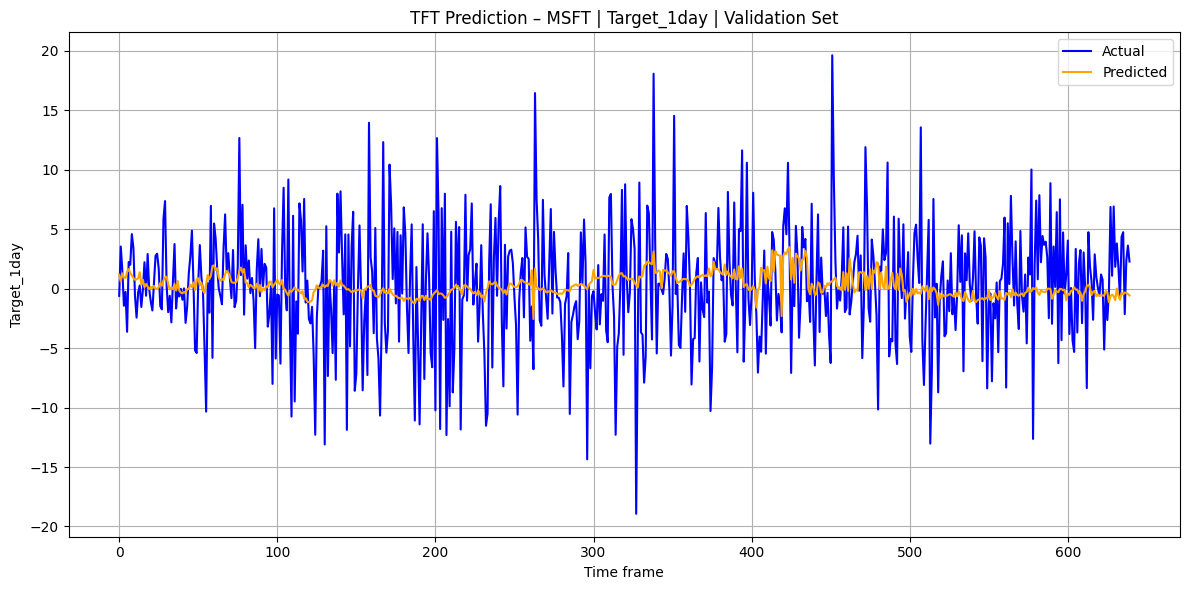

In [ ]:
# Validation set visualization
plt.figure(figsize=(12, 6))
plt.plot(val_true[:val_min_length], label='Actual', color='blue')
plt.plot(val_pred[:val_min_length], label='Predicted', color='orange')
plt.title(f"TFT Prediction – {ticker} | {target} | Validation Set")
plt.xlabel('Time frame')
plt.ylabel(target)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

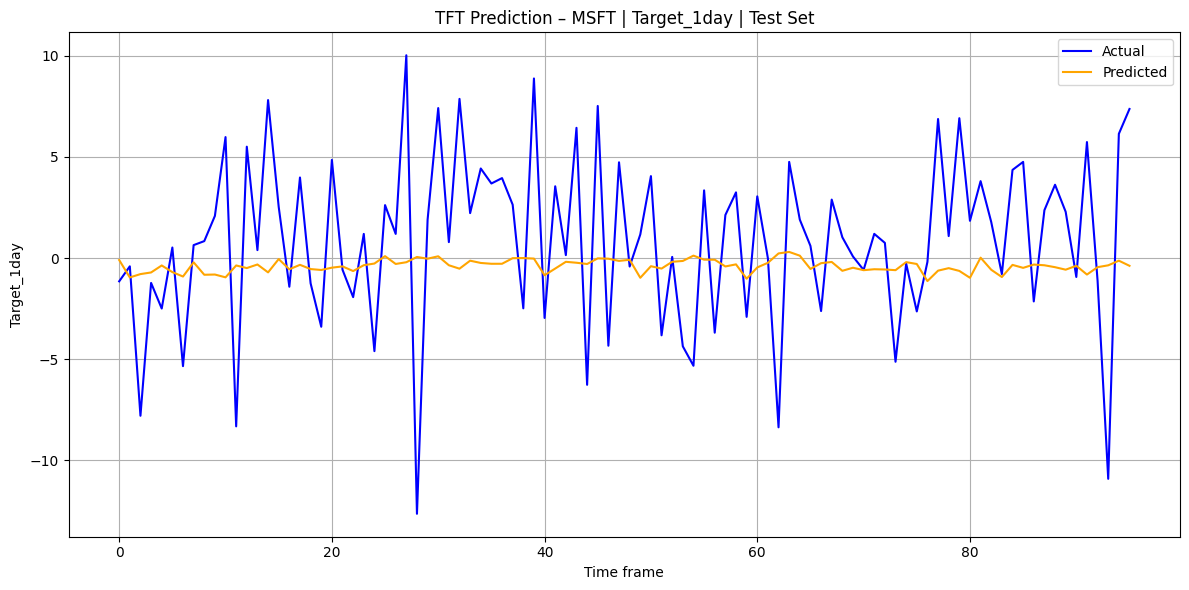

In [ ]:
# Test set visualization
plt.figure(figsize=(12, 6))
plt.plot(test_true[:test_min_length], label='Actual', color='blue')
plt.plot(test_pred[:test_min_length], label='Predicted', color='orange')
plt.title(f"TFT Prediction – {ticker} | {target} | Test Set")
plt.xlabel('Time frame')
plt.ylabel(target)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# Save the plot
filename = f'msft_tft_{target}.png'
plt.savefig(filename)
plt.show()

<Figure size 640x480 with 0 Axes>

In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime
import csv
from pathlib import Path

class ModelResultsTracker:
    def __init__(self, results_dir='model_results'):
        self.results_dir = Path(results_dir)
        self.results_dir.mkdir(exist_ok=True)
        self.results = []

    def add_result(self, ticker, target, encoder_length, model_type,
                   val_mae, val_rmse, val_r2, test_mae, test_rmse, test_r2):
        """Add a model run result"""
        result = {
            'timestamp': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
            'ticker': ticker,
            'target': target,
            'encoder_length': encoder_length,
            'model_type': model_type,
            'val_mae': val_mae,
            'val_rmse': val_rmse,
            'val_r2': val_r2,
            'test_mae': test_mae,
            'test_rmse': test_rmse,
            'test_r2': test_r2
        }
        self.results.append(result)

        # Auto-save after each addition
        self.save_results()

    def save_results(self):
        """Save results to CSV and TXT files"""
        # Save to CSV (append mode)
        df = pd.DataFrame(self.results)
        timestamp = datetime.now().strftime("%Y%m%d")
        csv_path = self.results_dir / f'model_results_{timestamp}.csv'

        # Check if file exists and append if it does
        if csv_path.exists():
            # Read existing data
            existing_df = pd.read_csv(csv_path)
            # Combine with new data
            combined_df = pd.concat([existing_df, df.iloc[-1:]], ignore_index=True)
            combined_df.to_csv(csv_path, index=False)
        else:
            df.to_csv(csv_path, index=False)

        # Save to formatted TXT (append mode)
        txt_path = self.results_dir / f'model_results_{timestamp}.txt'

        # Open in append mode
        mode = 'a' if txt_path.exists() else 'w'
        with open(txt_path, mode) as f:
            if mode == 'w':
                f.write("Model Performance Results\n")
                f.write("=" * 50 + "\n\n")

            # Only write the last result
            result = self.results[-1]
            f.write("Model Performance Results\n")
            f.write("=" * 50 + "\n\n")

            for result in self.results:
                f.write(f"Timestamp: {result['timestamp']}\n")
                f.write(f"Ticker: {result['ticker']} | Target: {result['target']}\n")
                f.write(f"Encoder Length: {result['encoder_length']} | Model: {result['model_type']}\n")
                f.write("-" * 50 + "\n")
                f.write("Validation Metrics:\n")
                f.write(f"  MAE: {result['val_mae']:.4f}\n")
                f.write(f"  RMSE: {result['val_rmse']:.4f}\n")
                f.write(f"  R²: {result['val_r2']:.4f}\n")
                f.write("Test Metrics:\n")
                f.write(f"  MAE: {result['test_mae']:.4f}\n")
                f.write(f"  RMSE: {result['test_rmse']:.4f}\n")
                f.write(f"  R²: {result['test_r2']:.4f}\n")
                f.write("=" * 50 + "\n\n")

        print(f"Results saved to {csv_path} and {txt_path}")

    def get_summary_table(self):
        """Get a summary table of all results"""
        df = pd.DataFrame(self.results)
        if len(df) > 0:
            # Create a pivot table for easy comparison
            pivot = df.pivot_table(
                values=['val_r2', 'test_r2'],
                index=['ticker', 'target'],
                columns=['encoder_length'],
                aggfunc='mean'
            )
            return pivot
        return None

    def plot_results(self, metric='r2'):
        """Create visualization of results"""
        import matplotlib.pyplot as plt

        df = pd.DataFrame(self.results)
        if len(df) == 0:
            print("No results to plot")
            return

        # Create a figure with subplots
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

        # Validation R² by target and encoder length
        for target in df['target'].unique():
            target_data = df[df['target'] == target]
            ax1.plot(target_data['encoder_length'], target_data['val_r2'],
                    marker='o', label=target)

        ax1.set_xlabel('Encoder Length')
        ax1.set_ylabel('Validation R²')
        ax1.set_title('Validation R² by Target and Encoder Length')
        ax1.legend()
        ax1.grid(True)

        # Test R² by target and encoder length
        for target in df['target'].unique():
            target_data = df[df['target'] == target]
            ax2.plot(target_data['encoder_length'], target_data['test_r2'],
                    marker='o', label=target)

        ax2.set_xlabel('Encoder Length')
        ax2.set_ylabel('Test R²')
        ax2.set_title('Test R² by Target and Encoder Length')
        ax2.legend()
        ax2.grid(True)

        plt.tight_layout()
        plt.savefig(self.results_dir / f'results_plot_{datetime.now().strftime("%Y%m%d")}.png')
        plt.show()

# Example usage
tracker = ModelResultsTracker()

# After each model run, add the results
tracker.add_result(
    ticker=ticker,
    target=target,
    encoder_length=max_encoder_length,
    model_type='TFT',
    val_mae=val_mae,
    val_rmse=val_rmse,
    val_r2=val_r2,
    test_mae=test_mae,
    test_rmse=test_rmse,
    test_r2=test_r2
)

Results saved to model_results/model_results_20250425.csv and model_results/model_results_20250425.txt


In [391]:
# Or use this to remove widget metadata
!jupyter nbconvert --ClearMetadataPreprocessor.enabled=True --clear-output --inplace your_notebook.ipynb

[NbConvertApp] WARNING | pattern 'your_notebook.ipynb' matched no files
This application is used to convert notebook files (*.ipynb)
        to various other formats.


Options
The options below are convenience aliases to configurable class-options,
as listed in the "Equivalent to" description-line of the aliases.
To see all configurable class-options for some <cmd>, use:
    <cmd> --help-all

--debug
    set log level to logging.DEBUG (maximize logging output)
    Equivalent to: [--Application.log_level=10]
--show-config
    Show the application's configuration (human-readable format)
    Equivalent to: [--Application.show_config=True]
--show-config-json
    Show the application's configuration (json format)
    Equivalent to: [--Application.show_config_json=True]
--generate-config
    generate default config file
    Equivalent to: [--JupyterApp.generate_config=True]
-y
    Answer yes to any questions instead of prompting.
    Equivalent to: [--JupyterApp.answer_yes=True]
--execute
 